# Part 1: Model Run-off (Systematic Model Selection)

## Introduction

In this part, you'll implement a systematic approach to model selection for healthcare data. You'll compare multiple model architectures, evaluate their performance, and select the best model based on various metrics.

## Learning Objectives

- Implement a systematic model selection process
- Compare multiple model architectures
- Apply cross-validation techniques
- Analyze performance trade-offs
- Save model and metrics in the correct format

## Setup and Installation

In [ ]:
# Install required packages
%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
sns.set_theme()  # had error using seaborn
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

Note: you may need to restart the kernel to use updated packages.


## 1. Data Loading and Preprocessing

In [5]:
# Load healthcare dataset
# This is a placeholder - replace with your actual dataset loading code
# Example:
# from sklearn.datasets import load_breast_cancer
# data = load_breast_cancer()
# X, y = data.data, data.target

# For demonstration, we'll use a synthetic dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                          n_redundant=5, n_classes=2, random_state=42)

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Dataset shape: (1000, 20)
Number of classes: 2
Class distribution: [497 503]
Training set shape: (700, 20)
Validation set shape: (150, 20)
Test set shape: (150, 20)


## 2. Model Definitions

In [6]:
# Define multiple model architectures to compare

def create_model_1(input_shape, num_classes):
    """
    Simple neural network with 2 hidden layers
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_2(input_shape, num_classes):
    """
    Deeper neural network with 4 hidden layers
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_3(input_shape, num_classes):
    """
    Wide neural network with residual connections
    """
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Residual block 1
    block_1 = tf.keras.layers.Dense(256, activation='relu')(x)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    block_1 = tf.keras.layers.Dense(256, activation='relu')(block_1)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    x = tf.keras.layers.add([x, block_1])
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model instances
model_1 = create_model_1(X_train.shape[1], len(np.unique(y)))
model_2 = create_model_2(X_train.shape[1], len(np.unique(y)))
model_3 = create_model_3(X_train.shape[1], len(np.unique(y)))

# Print model summaries
print("Model 1 Summary:")
model_1.summary()
print("\nModel 2 Summary:")
model_2.summary()
print("\nModel 3 Summary:")
model_3.summary()

Model 1 Summary:


/home/codespace/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-20 22:38:54.587147: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,874 (15.13 KB)

 Trainable params: 3,682 (14.38 KB)

 Non-trainable params: 192 (768.00 B)


Model 2 Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,546 (56.82 KB)

 Trainable params: 14,066 (54.95 KB)

 Non-trainable params: 480 (1.88 KB)


Model 3 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │      5,376 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_6[0][0],  │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        514 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,546 (549.01 KB)

 Trainable params: 139,010 (543.01 KB)

 Non-trainable params: 1,536 (6.00 KB)

## 3. Cross-Validation and Model Selection

Evaluating Model 1...
Fold 1: Accuracy = 0.9357
Fold 2: Accuracy = 0.9357
Fold 3: Accuracy = 0.9000
Fold 4: Accuracy = 0.9143
Fold 5: Accuracy = 0.8786
Model 1 Mean Accuracy: 0.9129, Std: 0.0219

Evaluating Model 2...
Fold 1: Accuracy = 0.9571
Fold 2: Accuracy = 0.9286
Fold 3: Accuracy = 0.9286
Fold 4: Accuracy = 0.9071
Fold 5: Accuracy = 0.9143
Model 2 Mean Accuracy: 0.9271, Std: 0.0171

Evaluating Model 3...
Fold 1: Accuracy = 0.9357
Fold 2: Accuracy = 0.9857
Fold 3: Accuracy = 0.9143
Fold 4: Accuracy = 0.9357
Fold 5: Accuracy = 0.9286
Model 3 Mean Accuracy: 0.9400, Std: 0.0242


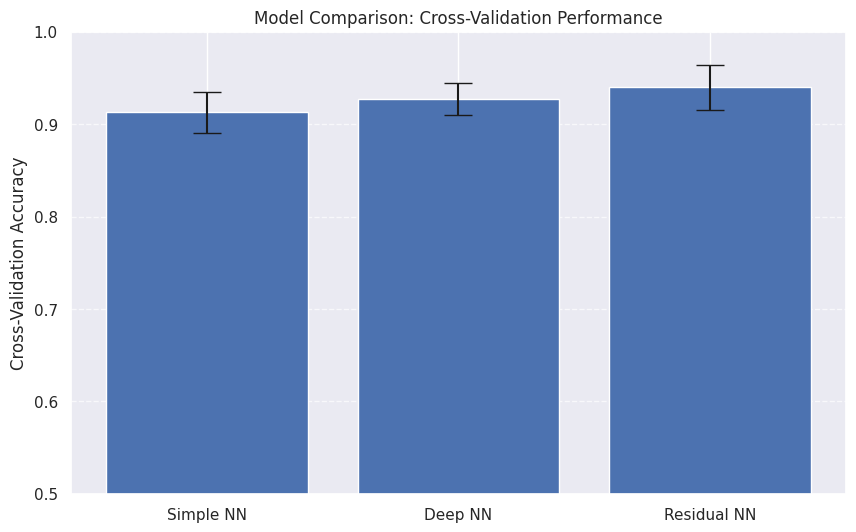

Best model based on cross-validation: Residual NN


In [7]:
# Define a function to evaluate models using cross-validation
def evaluate_model_cv(model_fn, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create and train model
        model = model_fn(X.shape[1], len(np.unique(y)))
        model.fit(
            X_train_fold, y_train_fold,
            epochs=50,
            batch_size=32,
            verbose=0,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        
        # Evaluate model
        _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        scores.append(accuracy)
        
        print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")
    
    return scores

# Evaluate models using cross-validation
print("Evaluating Model 1...")
model_1_scores = evaluate_model_cv(create_model_1, X_train_scaled, y_train)
print(f"Model 1 Mean Accuracy: {np.mean(model_1_scores):.4f}, Std: {np.std(model_1_scores):.4f}")

print("\nEvaluating Model 2...")
model_2_scores = evaluate_model_cv(create_model_2, X_train_scaled, y_train)
print(f"Model 2 Mean Accuracy: {np.mean(model_2_scores):.4f}, Std: {np.std(model_2_scores):.4f}")

print("\nEvaluating Model 3...")
model_3_scores = evaluate_model_cv(create_model_3, X_train_scaled, y_train)
print(f"Model 3 Mean Accuracy: {np.mean(model_3_scores):.4f}, Std: {np.std(model_3_scores):.4f}")

# Compare model performance
model_names = ['Simple NN', 'Deep NN', 'Residual NN']
mean_scores = [np.mean(model_1_scores), np.mean(model_2_scores), np.mean(model_3_scores)]
std_scores = [np.std(model_1_scores), np.std(model_2_scores), np.std(model_3_scores)]

plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_scores, yerr=std_scores, capsize=10)
plt.ylim(0.5, 1.0)
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison: Cross-Validation Performance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Select the best model based on cross-validation
best_model_idx = np.argmax(mean_scores)
best_model_name = model_names[best_model_idx]
print(f"Best model based on cross-validation: {best_model_name}")

# Create and train the best model on the full training set
if best_model_idx == 0:
    best_model_fn = create_model_1
elif best_model_idx == 1:
    best_model_fn = create_model_2
else:
    best_model_fn = create_model_3

best_model = best_model_fn(X_train.shape[1], len(np.unique(y)))

## 4. Training and Evaluation of Best Model

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5687 - loss: 1.1618 - val_accuracy: 0.9133 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8415 - loss: 0.4582 - val_accuracy: 0.9067 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9003 - loss: 0.2386 - val_accuracy: 0.9467 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9145 - loss: 0.2595 - val_accuracy: 0.9533 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9312 - loss: 0.2211 - val_accuracy: 0.9600 - val_loss: 0.2577 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9277 - loss: 0.1920 - val_accuracy: 0.9267 - val_loss: 0.2198 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9506 - loss: 0.1559 - val_

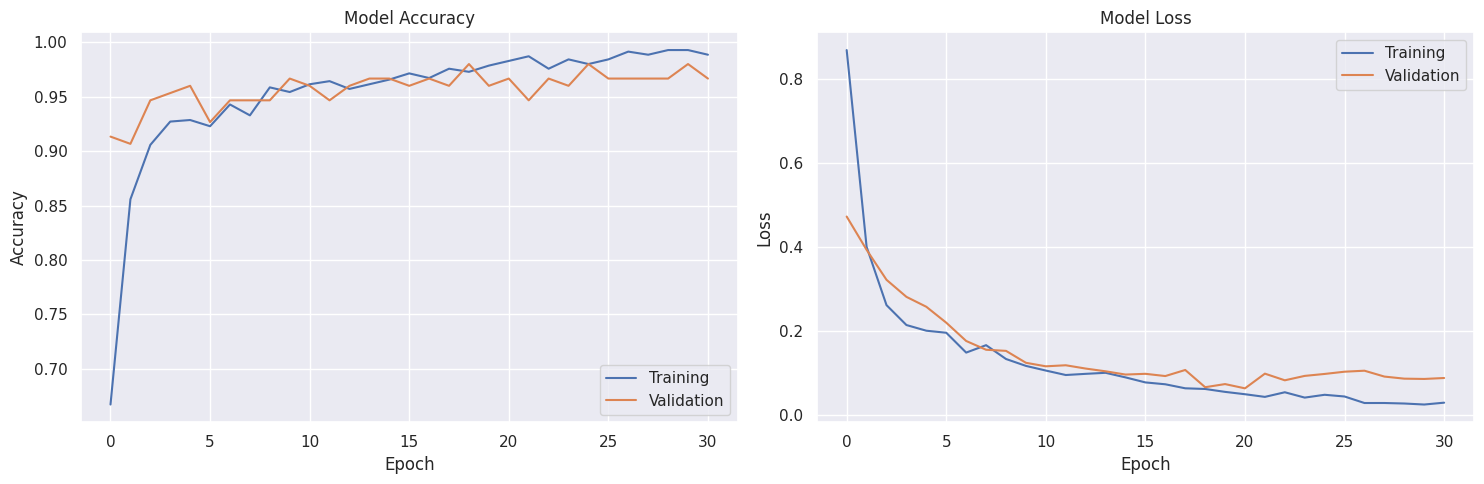

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9059 - loss: 0.1873 
Test accuracy: 0.9000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


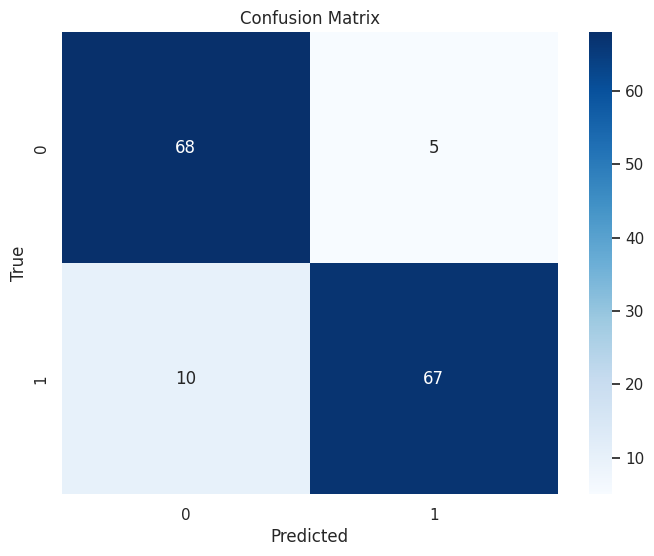

In [8]:
# Define callbacks for the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/best_model.keras',
        save_best_only=True
    )
]

# Train the best model
history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluate best model on test set
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = best_model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': best_model_name,
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist()
}

# Save to file
with open('results/part_1/model_comparison.txt', 'w') as f:
    f.write(f"best_model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    
    # Also save cross-validation results
    f.write("\n--- Cross-Validation Results ---\n")
    f.write(f"model_1_mean_accuracy: {np.mean(model_1_scores)}\n")
    f.write(f"model_1_std_accuracy: {np.std(model_1_scores)}\n")
    f.write(f"model_2_mean_accuracy: {np.mean(model_2_scores)}\n")
    f.write(f"model_2_std_accuracy: {np.std(model_2_scores)}\n")
    f.write(f"model_3_mean_accuracy: {np.mean(model_3_scores)}\n")
    f.write(f"model_3_std_accuracy: {np.std(model_3_scores)}\n")

## 5. Model Complexity Analysis

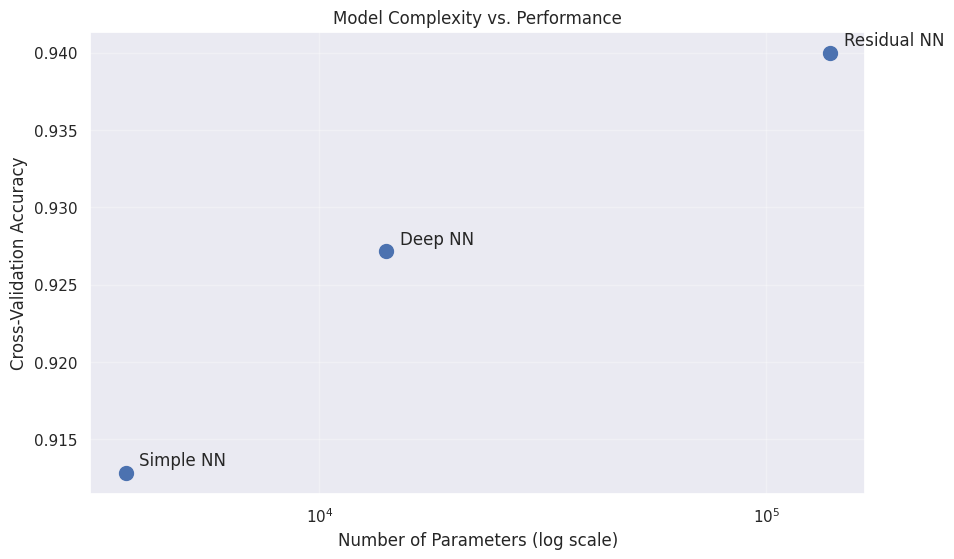

In [ ]:
# Analyze model complexity vs. performance
def count_parameters(model):
    #return np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables]) # had error
    return np.sum([np.prod(v.shape.as_list()) for v in model.trainable_variables])


model_1 = create_model_1(X_train.shape[1], len(np.unique(y)))
model_2 = create_model_2(X_train.shape[1], len(np.unique(y)))
model_3 = create_model_3(X_train.shape[1], len(np.unique(y)))

param_counts = [count_parameters(model_1), count_parameters(model_2), count_parameters(model_3)]


# Plot model complexity vs. performance
plt.figure(figsize=(10, 6))
plt.scatter(param_counts, mean_scores, s=100)

for i, (x, y) in enumerate(zip(param_counts, mean_scores)):
    plt.annotate(model_names[i], (x, y), xytext=(10, 5), textcoords='offset points')

plt.xscale('log')
plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Complexity vs. Performance')
plt.grid(True, alpha=0.3)
plt.show()

# Save complexity analysis
with open('results/part_1/model_comparison.txt', 'a') as f:
    f.write("\n--- Model Complexity Analysis ---\n")
    for i, name in enumerate(model_names):
        f.write(f"{name}_parameters: {param_counts[i]}\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load healthcare dataset
   - [ ] Verify data shapes and ranges
   - [ ] Split data into train/validation/test sets

2. **Model Definition**:
   - [ ] Define at least 3 different model architectures
   - [ ] Verify architecture differences
   - [ ] Ensure models are properly compiled

3. **Cross-Validation**:
   - [ ] Implement k-fold cross-validation
   - [ ] Evaluate all models using cross-validation
   - [ ] Compare model performance

4. **Best Model Training**:
   - [ ] Train best model with appropriate callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Analyze model complexity vs. performance
   - [ ] Save metrics in correct format

## Common Issues and Solutions

1. **Data Issues**:
   - Problem: Imbalanced classes
   - Solution: Use class weights or resampling techniques
   - Problem: Feature scaling
   - Solution: Apply standardization or normalization

2. **Model Selection Issues**:
   - Problem: Overfitting in complex models
   - Solution: Add regularization, dropout, or early stopping
   - Problem: Underfitting in simple models
   - Solution: Increase model capacity or feature engineering

3. **Cross-Validation Issues**:
   - Problem: High variance in CV scores
   - Solution: Increase number of folds or use stratified sampling
   - Problem: Slow CV process
   - Solution: Reduce epochs for CV or use a subset of data

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below expectations
   - Solution: Try different architectures or hyperparameter tuning